# JAM FITTER

In [1]:
import sys,os
from fitlab.resman import RESMAN
from fitlab.mcsamp import MCSAMP
from tools.config import load_config,conf
from tools.tools import load, save,checkdir
import pylab as py
import numpy as np
import pandas as pd
import copy
def lprint(msg):
    sys.stdout.write('\r')
    sys.stdout.write('%s' %msg)
    sys.stdout.flush()
%matplotlib inline

## setup path to store the results 

In [2]:
path2results='sidis_upol'
checkdir(path2results)

## data sets 

In [3]:
conf['datasets']={}

## SIDIS FUU 

In [4]:
conf['datasets']['sidis']={}
conf['datasets']['sidis']['filters']={}
conf['datasets']['sidis']['filters'][0]={}
conf['datasets']['sidis']['filters'][0]['idx']=[1000,1001,1004,1005,1002,1003,1006,1007]
#conf['datasets']['sidis']['filters'][0]['filter']="z<0.6 and Q2>1.69 and pT>0.2 and pT<0.9 and dy > 3"
conf['datasets']['sidis']['filters'][0]['filter']="z<0.6 and Q2>1.69 and pT>0.2 and pT<0.9"


conf['datasets']['sidis']['xlsx']={}
conf['datasets']['sidis']['xlsx'][1000]='sidis/expdata/1000.xlsx'  # |  proton   | pi+    | M_Hermes | hermes 
conf['datasets']['sidis']['xlsx'][1001]='sidis/expdata/1001.xlsx'  # |  proton   | pi-    | M_Hermes | hermes 
conf['datasets']['sidis']['xlsx'][1004]='sidis/expdata/1004.xlsx'  # |  deuteron | pi+    | M_Hermes | hermes 
conf['datasets']['sidis']['xlsx'][1005]='sidis/expdata/1005.xlsx'  # |  deuteron | pi-    | M_Hermes | hermes 

conf['datasets']['sidis']['norm']={}
for k in conf['datasets']['sidis']['xlsx']: conf['datasets']['sidis']['norm'][k]={'value':1,'fixed':True,'min':0,'max':1} 


## parameters

In [5]:
conf['params']={}

### pion PDF parameters

In [6]:
conf['params']['pdf']={}
conf['params']['pdf']['widths0 valence']  = {'value':0.5,'fixed':False,'min':0,'max':1}
conf['params']['pdf']['widths0 sea']      = {'value':0.5,'fixed':False,'min':0,'max':1}

In [7]:
conf['params']['ff']={}
conf['params']['ff']['widths0 pi+ fav']   = {'value':0.5,'fixed':False,'min':0,'max':1}
conf['params']['ff']['widths0 pi+ unfav'] = {'value':0.5,'fixed':False,'min':0,'max':1}

## Nested Sampling

### initialize fitpack libraries

In [8]:
conf['resman'] = RESMAN()
mcsamp=MCSAMP()

loading sidis data sets 1005
multiprocess setup: ncpus=1 / observable


### start multiple NS runs
- the code will start n independent runs specified by size

In [9]:
mcsamp.run(path2results,factor=4, size=4)

iter=678  logz=-197.337 rel-err=9.700e-11  t-elapsed=5.420e+01  dchi2min=3.618e+02 dchi2max=3.618e+02

### combine multiple runs into one big run

In [10]:
MC=mcsamp.get_MC_samples(path2results+'/mcdata')

runs max likelihoods
180.89157107396903
141.07872439806113
142.3476933386491
140.4574001331581
sample  size= 2463
sample2 size= 408


### distribution of parameters

     widths0 valence =    0.59626 +/-    0.01386
         widths0 sea =    0.51770 +/-    0.07932
     widths0 pi+ fav =    0.11530 +/-    0.00128
   widths0 pi+ unfav =    0.13948 +/-    0.00156


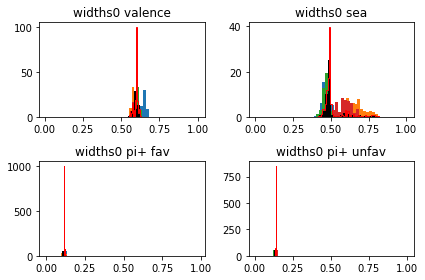

In [11]:
samples=MC['samples']
samples2=MC['samples2']
weights=MC['weights']
weights2=MC['weights2']
order=MC['order']
runs=MC['runs']

nrows,ncols=2,2
fig = py.figure(figsize=(ncols*3,nrows*2))

def get_idx(key,tag):
    for i in range(len(order)):
        if order[i][1]==key and order[i][2]==tag:
            return i

global cnt
cnt=0
def plot(tags):
    global cnt
    for i in range(1,len(tags)):
        cnt+=1
        if tags[i]==None: continue
        idx=get_idx(tags[0],tags[i])
        ax=py.subplot(nrows,ncols,cnt)
        vmin=np.amin(samples2.T[idx])
        vmax=np.amax(samples2.T[idx])
        R=None#(vmin,vmax)
        for k in runs:
            ax.hist(runs[k]['samples'].T[idx],weights=runs[k]['weights'],bins=50,normed=True,range=R)
        ax.hist(samples.T[idx],weights=weights,bins=50,color='k',normed=True,range=R)
        ax.hist(samples2.T[idx],weights=weights2,bins=50,color='r',histtype='step',normed=True,range=R)
        ax.set_title(tags[i])
        mean=np.einsum('i,i',samples2.T[idx],weights2)
        std=np.einsum('i,i',(samples2.T[idx]-mean)**2,weights2)**0.5
        print '%20s = %10.5f +/- %10.5f'%(tags[i],mean,std)
        #ax.set_xlim(vmin,vmax)
    py.tight_layout()

plot(['pdf','widths0 valence','widths0 sea'])
plot(['ff','widths0 pi+ fav','widths0 pi+ unfav'])


## data vs theory

In [12]:
data={'weights':MC['weights2']}
cnt=0
for s in MC['samples2']:
    cnt+=1    
    lprint('%d/%d'%(cnt,len(MC['samples2'])))  
    conf['resman'].get_residuals(s);
    for k in conf['resman'].sidisres.tabs:
        if k  not in data: data[k]=[]
        thy=conf['resman'].sidisres.tabs[k]['thy']    
        norm=conf['datasets']['sidis']['norm'][k]['value']
        shift=conf['resman'].sidisres.tabs[k]['shift']        
        data[k].append(shift+thy/norm)
save(data,'%s/%s'%(path2results,'sidis.dat'))   

408/408

### compute averages and collect results

In [13]:
data=load('%s/%s'%(path2results,'sidis.dat'))   
for k in data: data[k]=np.array(data[k])
thy,dthy={},{}
for k in data:
    if k=='weights': continue
    thy[k]=np.einsum('i,ik->k',data['weights'],data[k])
    dthy[k]=np.einsum('i,ik->k',data['weights'],(data[k]-thy[k])**2)**0.5
for k in thy: 
    conf['resman'].sidisres.tabs[k]['thy']=copy.copy(thy[k])
    conf['resman'].sidisres.tabs[k]['dthy']=copy.copy(dthy[k])

In [14]:
report=conf['resman'].gen_report(verb=0,level=1)
delimiters=[]
for i in range(len(report)): 
    if 'reaction:' in report[i]: delimiters.append(i) 

data={}
nlines=len(report)
for i in range(len(delimiters)):
    ini=delimiters[i]
    if i==len(delimiters)-1: fin=len(report)
    else: fin=delimiters[i+1]
    reaction=report[ini].replace('reaction:','').strip()
    data[reaction]={'raw data':report[ini:fin]}
    
for k in data:
    print k
    block=data[k]['raw data']
    isep=[i for i in range(len(block)) if '--------' in block[i]][0]
    data[k]['summary']=[block[i] for i in range(isep)]
    data[k]['tables']=[block[i] for i in range(isep+1,len(block))]

    tabs={}
    for l in data[k]['tables']:
        info=l.split(',')
        col=[s for s in info if 'col' in s][0].split('=')[1].strip()
        if col not in tabs: tabs[col]={}
        info=[[ss.strip() for ss in s.split('=')] for s in info if 'col' not in info  if s.strip()!='']
        
        for s in info:
            if s[0] not in tabs[col]: tabs[col][s[0]]=[]
        
        for s in info:
            try:
                value=float(s[1])
            except:
                value=s[1]
            tabs[col][s[0]].append(value)        

    data[k]['tabs']=tabs
save(data,'%s/%s'%(path2results,'data_and_thy.dat'))  

sidis


In [15]:
def summary():
    for k in data:
        print ""
        for l in data[k]['summary']: print l
summary()


reaction: sidis
    idx        tar        had        col        obs  npts       chi2      rchi2      nchi2
   1000     proton        pi+     hermes   M_Hermes   127     315.47       0.00       0.00
   1001     proton        pi-     hermes   M_Hermes   124     161.86       0.00       0.00
   1004   deuteron        pi+     hermes   M_Hermes   124     154.20       0.00       0.00
   1005   deuteron        pi-     hermes   M_Hermes   122     153.87       0.00       0.00


### plot data and theory

In [16]:
data=load('%s/%s'%(path2results,'data_and_thy.dat'))

### 1000

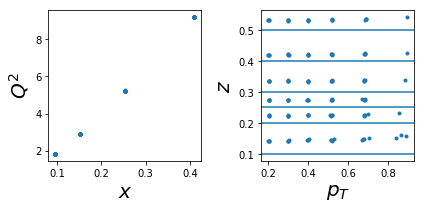

In [17]:
tab=pd.DataFrame(data['sidis']['tabs']['hermes']).query('idx==1000')
tab['xr']=[np.round(x,2) for x in tab.x]
ZR=[[0.1,0.2],[0.2,0.25],[0.25,0.3],[0.3,0.4],[0.4,0.5],[0.5,1]]

nrows,ncols=1,2
fig = py.figure(figsize=(ncols*3,nrows*3))
ax=py.subplot(nrows,ncols,1)
ax.plot(tab['x'],tab['Q2'],'.'); ax.set_xlabel(r'$x$',size=20); ax.set_ylabel(r'$Q^2$',size=20)
ax=py.subplot(nrows,ncols,2)
ax.plot(tab['pT'],tab['z'],'.'); ax.set_xlabel(r'$p_T$',size=20); ax.set_ylabel(r'$z$',size=20);
for zr in ZR: ax.axhline(y=zr[0]);
py.tight_layout()

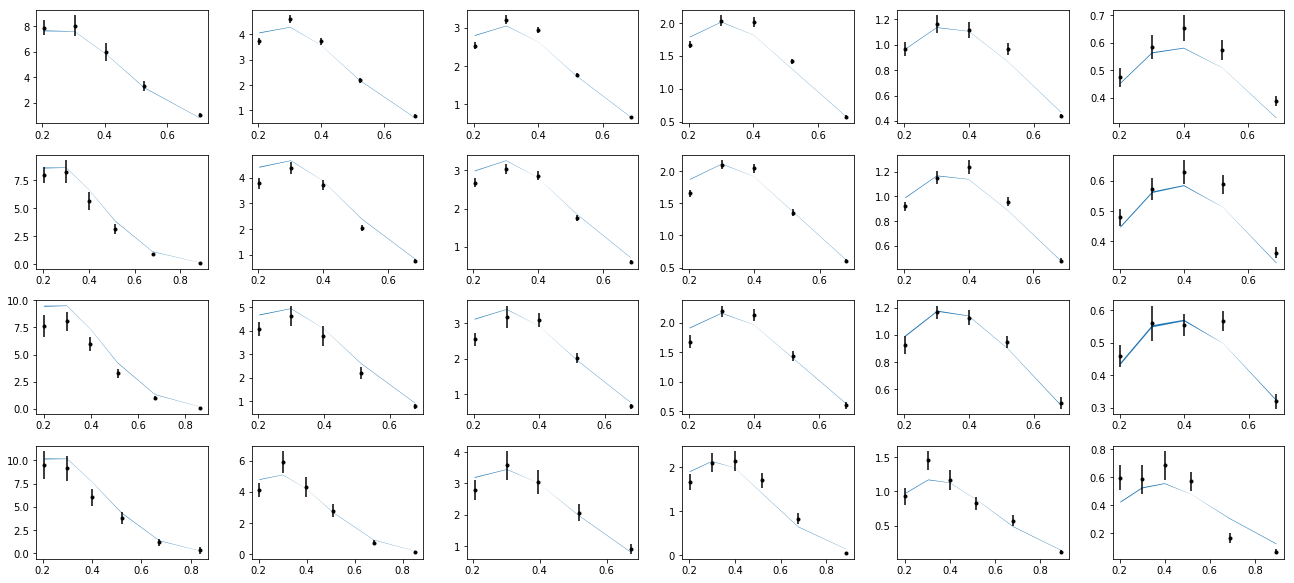

In [18]:
nrows,ncols=6,6
fig = py.figure(figsize=(ncols*3,nrows*2))
cnt=0
for xr in np.unique(tab['xr']):
    tabx=tab.query('xr==%f'%xr)
    for zr in ZR:
        tabz=tabx.query('z>%f and z<%f'%(zr[0],zr[1]))
        cnt+=1
        ax=py.subplot(nrows,ncols,cnt)
        ax.errorbar(tabz['pT'],tabz['exp'],yerr=tabz['alpha'],fmt='k.')
        ax.fill_between(tabz['pT'],tabz['thy']-tabz['dthy'],tabz['thy']+tabz['dthy'])
        
py.tight_layout()

### 1001

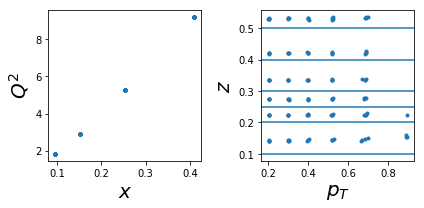

In [19]:
tab=pd.DataFrame(data['sidis']['tabs']['hermes']).query('idx==1001')
tab['xr']=[np.round(x,2) for x in tab.x]
ZR=[[0.1,0.2],[0.2,0.25],[0.25,0.3],[0.3,0.4],[0.4,0.5],[0.5,1]]

nrows,ncols=1,2
fig = py.figure(figsize=(ncols*3,nrows*3))
ax=py.subplot(nrows,ncols,1)
ax.plot(tab['x'],tab['Q2'],'.'); ax.set_xlabel(r'$x$',size=20); ax.set_ylabel(r'$Q^2$',size=20)
ax=py.subplot(nrows,ncols,2)
ax.plot(tab['pT'],tab['z'],'.'); ax.set_xlabel(r'$p_T$',size=20); ax.set_ylabel(r'$z$',size=20);
for zr in ZR: ax.axhline(y=zr[0]);
py.tight_layout()

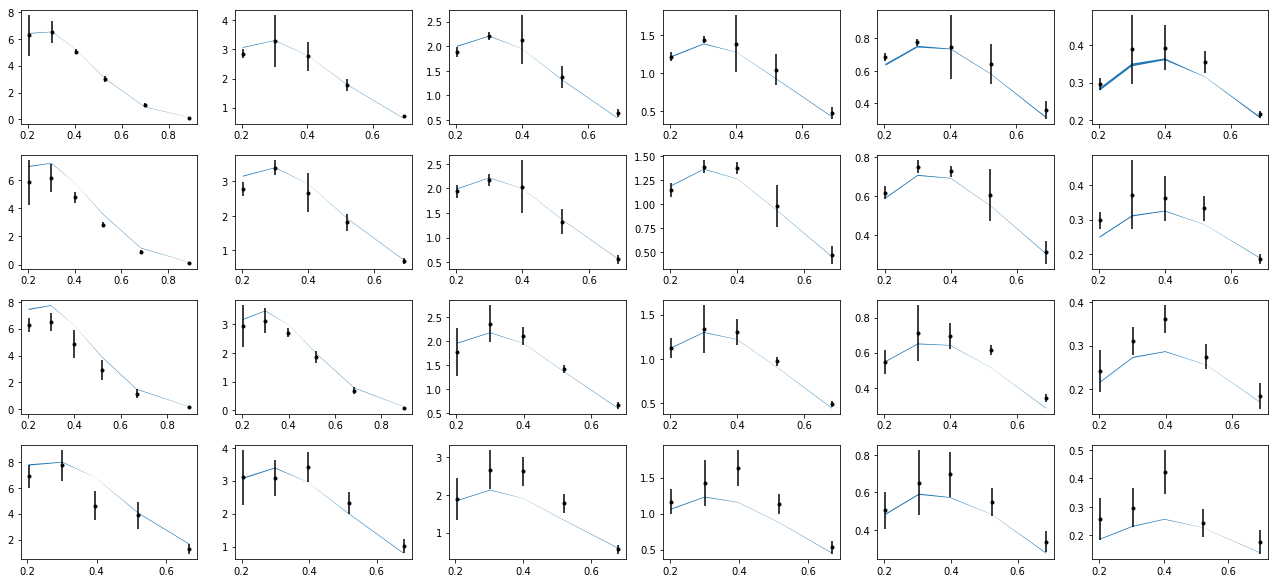

In [20]:
nrows,ncols=6,6
fig = py.figure(figsize=(ncols*3,nrows*2))
cnt=0
for xr in np.unique(tab['xr']):
    tabx=tab.query('xr==%f'%xr)
    for zr in ZR:
        tabz=tabx.query('z>%f and z<%f'%(zr[0],zr[1]))
        cnt+=1
        ax=py.subplot(nrows,ncols,cnt)
        ax.errorbar(tabz['pT'],tabz['exp'],yerr=tabz['alpha'],fmt='k.')
        ax.fill_between(tabz['pT'],tabz['thy']-tabz['dthy'],tabz['thy']+tabz['dthy'])
        
py.tight_layout()

### 1004

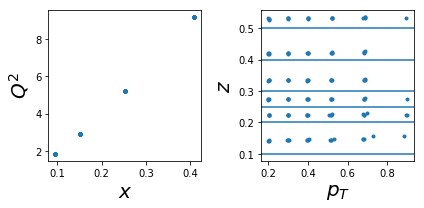

In [21]:
tab=pd.DataFrame(data['sidis']['tabs']['hermes']).query('idx==1004')
tab['xr']=[np.round(x,2) for x in tab.x]
ZR=[[0.1,0.2],[0.2,0.25],[0.25,0.3],[0.3,0.4],[0.4,0.5],[0.5,1]]

nrows,ncols=1,2
fig = py.figure(figsize=(ncols*3,nrows*3))
ax=py.subplot(nrows,ncols,1)
ax.plot(tab['x'],tab['Q2'],'.'); ax.set_xlabel(r'$x$',size=20); ax.set_ylabel(r'$Q^2$',size=20)
ax=py.subplot(nrows,ncols,2)
ax.plot(tab['pT'],tab['z'],'.'); ax.set_xlabel(r'$p_T$',size=20); ax.set_ylabel(r'$z$',size=20);
for zr in ZR: ax.axhline(y=zr[0]);
py.tight_layout()

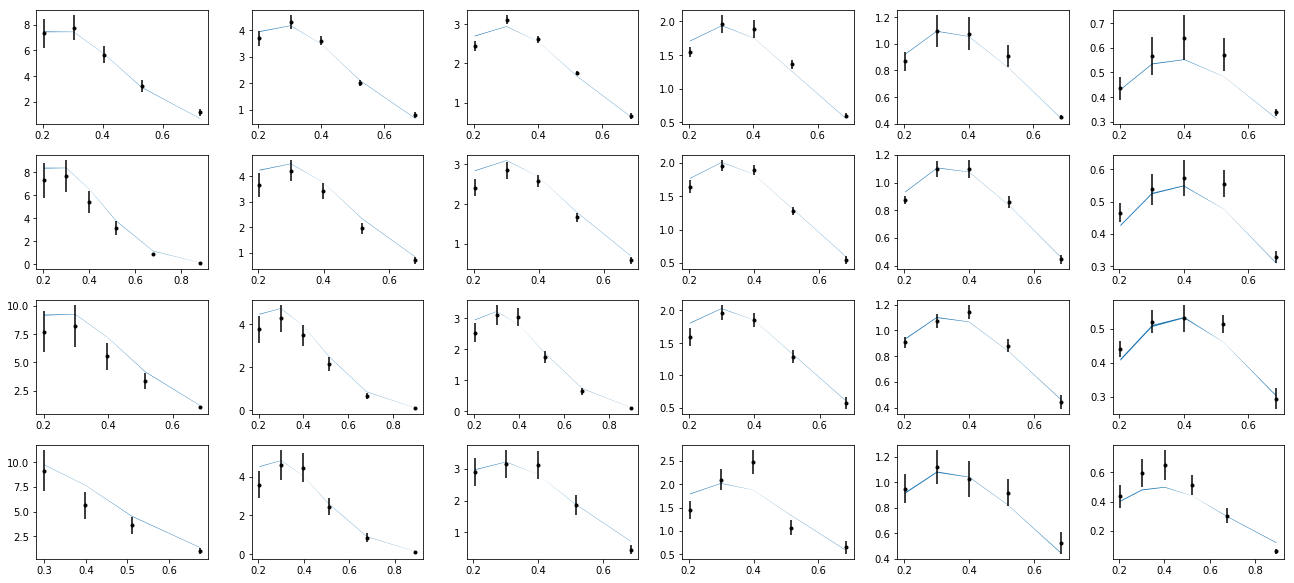

In [22]:
nrows,ncols=6,6
fig = py.figure(figsize=(ncols*3,nrows*2))
cnt=0
for xr in np.unique(tab['xr']):
    tabx=tab.query('xr==%f'%xr)
    for zr in ZR:
        tabz=tabx.query('z>%f and z<%f'%(zr[0],zr[1]))
        cnt+=1
        ax=py.subplot(nrows,ncols,cnt)
        ax.errorbar(tabz['pT'],tabz['exp'],yerr=tabz['alpha'],fmt='k.')
        ax.fill_between(tabz['pT'],tabz['thy']-tabz['dthy'],tabz['thy']+tabz['dthy'])
        
py.tight_layout()

### 1005

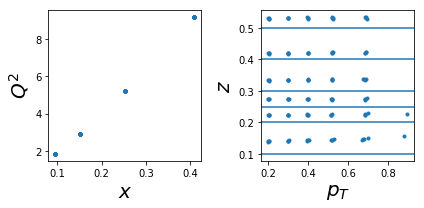

In [23]:
tab=pd.DataFrame(data['sidis']['tabs']['hermes']).query('idx==1005')
tab['xr']=[np.round(x,2) for x in tab.x]
ZR=[[0.1,0.2],[0.2,0.25],[0.25,0.3],[0.3,0.4],[0.4,0.5],[0.5,1]]

nrows,ncols=1,2
fig = py.figure(figsize=(ncols*3,nrows*3))
ax=py.subplot(nrows,ncols,1)
ax.plot(tab['x'],tab['Q2'],'.'); ax.set_xlabel(r'$x$',size=20); ax.set_ylabel(r'$Q^2$',size=20)
ax=py.subplot(nrows,ncols,2)
ax.plot(tab['pT'],tab['z'],'.'); ax.set_xlabel(r'$p_T$',size=20); ax.set_ylabel(r'$z$',size=20);
for zr in ZR: ax.axhline(y=zr[0]);
py.tight_layout()

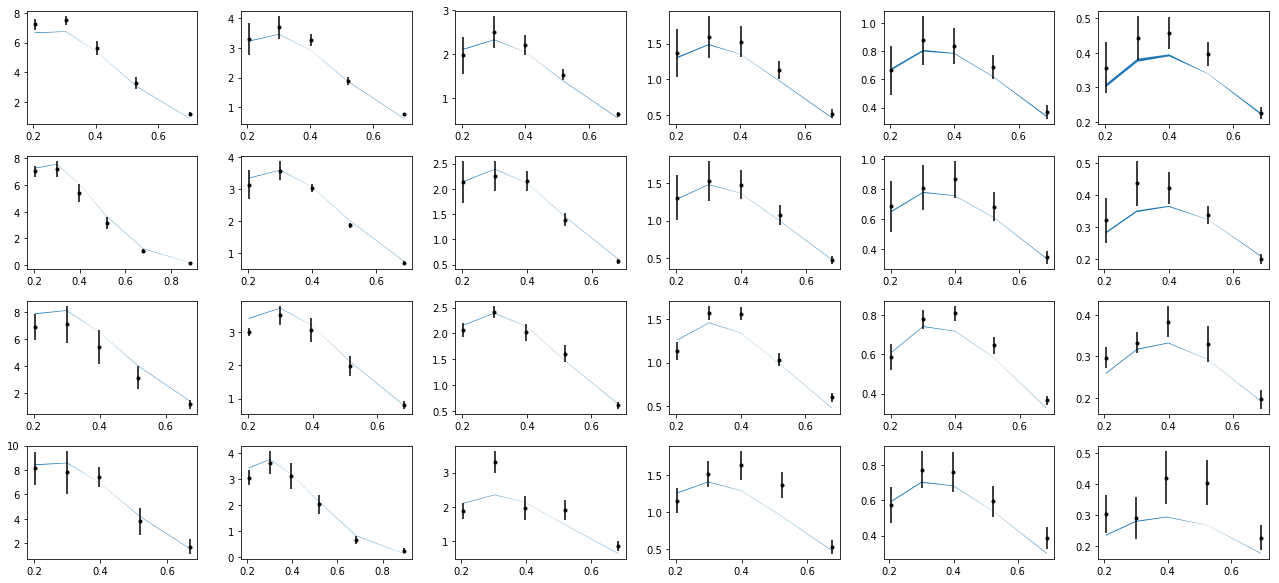

In [24]:
nrows,ncols=6,6
fig = py.figure(figsize=(ncols*3,nrows*2))
cnt=0
for xr in np.unique(tab['xr']):
    tabx=tab.query('xr==%f'%xr)
    for zr in ZR:
        tabz=tabx.query('z>%f and z<%f'%(zr[0],zr[1]))
        cnt+=1
        ax=py.subplot(nrows,ncols,cnt)
        ax.errorbar(tabz['pT'],tabz['exp'],yerr=tabz['alpha'],fmt='k.')
        ax.fill_between(tabz['pT'],tabz['thy']-tabz['dthy'],tabz['thy']+tabz['dthy'])
        
py.tight_layout()